In [37]:
import logging
logger = logging.getLogger()
from collections import Callable, deque, namedtuple
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import shelve

from odictliteral import odict as odict
import theano_shim as shim

import mackelab as ml
import mackelab.plot

import sinn   # Install sinn from https://github.com/mackelab/sinn
from sinn.histories import Series
from sinn.history_functions import GaussianWhiteNoise, Step
import sinn.models as models
from sinn.models import Model
import sinn.analyze as anlz
from sinn.models.dummy_quadratic import DummyQuad

logger.setLevel(logging.INFO)
logging.debug("Root logging level set to 'DEBUG'.")
    # Without this line, calls to logger.info don't actually work
%matplotlib inline

In [38]:
plt.style.use('mldefault')
ml.plot.invert_color_values('axes.prop_cycle') # Prefer higher contrast

In [39]:
ml.plot.invert_color_values()

In [40]:
shim.load_theano()

Clear the caches, so we can first test creation

    with shelve.open('sinn.models.cache') as cache:
        cache.clear()
    with shelve.open('sinn.models.compilecache') as cache:
        cache.clear()

In [5]:
I = Step(name='I', 
         t0=0,       tn=10,      dt=0.01,
         baseline=0, height=3,
         start=1.,  stop=9.,
         symbolic=False)
I.set();
I.lock()

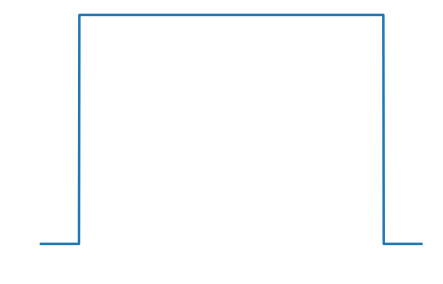

In [6]:
anlz.plot(I);

In [46]:
import theano

In [60]:
theano.tensor.as_tensor_variable?

Signature: theano.tensor.as_tensor_variable(x, name=None, ndim=None)
Docstring:
Return `x`, transformed into a `TensorType`.

This function is often used by `make_node` methods of `Op` subclasses
to turn ndarrays, numbers, `Scalar` instances, `Apply` instances and
`TensorType` instances into valid input list elements.

Parameters
----------
x : Apply instance, Variable instance, numpy.ndarray, or number
    This thing will be transformed into a `Variable` in a sensible way. An
    ndarray argument will not be copied, but a list of numbers will be
    copied to make an ndarray.
name : str or None
    If a new `Variable` instance is created, it will be named with this
    string.
ndim : None or integer
    Return a Variable with this many dimensions.

Raises
------
ValueError
    If an `Apply` with more than one output is fetched or
    if `x` cannot be made into a Variable with `ndim` dimensions.
AsTensorError
    If `x` cannot be converted to a TensorType Variable.
File:      ~/usr/ven

In [57]:
I._data

I data

In [51]:
theano.tensor.TensorConstant('int16', np.array(0))

AttributeError: 'str' object has no attribute 'filter'

In [7]:
with shelve.open('sinn.models.compilecache') as cache:
    print(list(cache.keys()))

['da39a3ee5e6b4b0d3255bfef95601890afd8070941b5906132680257d50c2371e9869f33a87e2328', 'dependencyhash']


In [8]:
X = Series(I, name='X', symbolic=None)
rng = shim.config.RandomStreams(314)
params = odict['α': 2., 'σ': 1.]
params = DummyQuad.Parameters(**{name: shim.shared(val) for name, val in params.items()})
dq = DummyQuad(params, X, I, rng)

In [9]:
with shelve.open('sinn.models.compilecache') as cache:
    print(list(cache.keys()))

['da39a3ee5e6b4b0d3255bfef95601890afd8070941b5906132680257d50c2371e9869f33a87e2328', 'dependencyhash']


In [10]:
X[0] = 0

    logger.setLevel(logging.DEBUG)

In [11]:
dq.advance('end')

INFO:sinn.models.common:Constructing the update graph.
INFO:sinn.models.common:Symbolic update graphs loaded from cache.
INFO:sinn.models.common:Done.
INFO:sinn.models.common:Compiling the update function
INFO:sinn.models.common:Compiled advance function loaded from cache
INFO:sinn.models.common:Done.


In [12]:
X2 = Series(I, name='X', symbolic=None)
rng2 = shim.config.RandomStreams(314)
    # RNG state is not taken from file (to allow changing it),
    # so we must set the same seed here as abvoe.
dq2 = DummyQuad(params, X2, I, rng2)

In [13]:
dq2.advance('end')

INFO:sinn.models.common:Constructing the update graph.
INFO:sinn.models.common:Symbolic update graphs loaded from cache.
INFO:sinn.models.common:Done.
INFO:sinn.models.common:Compiling the update function
INFO:sinn.models.common:Compiled advance function loaded from cache
INFO:sinn.models.common:Done.


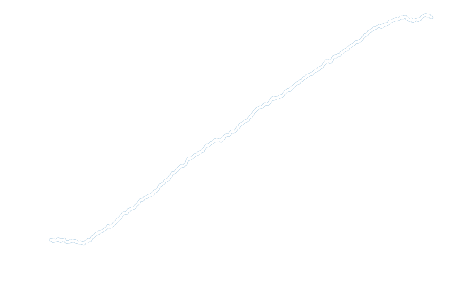

In [14]:
anlz.plot(dq.X)
anlz.plot(dq2.X)

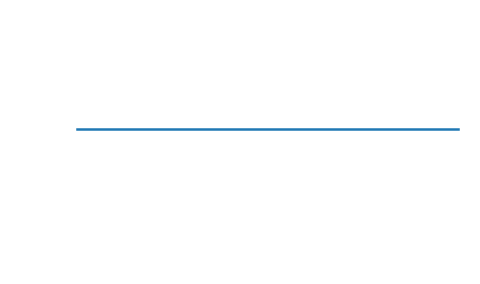

In [15]:
anlz.plot(dq.X.trace - dq2.X.trace)

In [15]:
dq.X.lock()

In [16]:
g = dq.logp(start=10, batch_size=100)

INFO:sinn.models.common:Symbolic update graphs loaded from cache.


In [13]:
g

0.9160921535851169

In [17]:
g.eval()

array(1.15419223)

| method | logp |
|---|--|
| theano | 1.15419223 |
| theano (direct) | 1.154192230811662 |
| numpy  | 0.9160921535851169 |
| numpy (direct)  | 0.91609215

In [33]:
dq.Xbar.clear()
Xbar = dq.Xbar[10:110].eval()

In [25]:
((dq.X.trace[10:110] - Xbar)**2).sum()

'Xbar data[Constant{10}]'

In [12]:
iX = dq.get_tidx_for(10, dq.X)
iXbar = dq.get_tidx_for(10, dq.Xbar)
np.sum((dq.X.data[iX:iX+100]-dq.Xbar.data[iXbar:iXbar+100])**2)

16.227554821541013